Authentication with DD-SIMCA
===

Author: Nathan A. Mahynski

Date: 2023/08/23

Description: Illustrate building authentication models with DD-SIMCA.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/simca.ipynb)

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [1]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

pychemauth: 0.0.0b4
numpy     : 1.24.3
matplotlib: 3.7.2
watermark : 2.4.3
imblearn  : 0.11.0
sklearn   : 1.3.0
pandas    : 1.5.3



<h3>Load the Data</h3>

In [4]:
from sklearn.datasets import load_iris as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [5]:
# Let's turn the indices into names
names = dict(zip(np.arange(3), ['setosa', 'versicolor', 'virginica']))
y = y.apply(lambda x: names[x])

In [6]:
X.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, # Let's try to predict the salary based on the other numerical features.
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

Fitting a DD-SIMCA Model
---

In [8]:
from pychemauth.classifier.simca import DDSIMCA_Model

<h3>Modeling a Single Class</h3>

(DD-)SIMCA is designed to model a single class - a different model is developed for each class, so we need to split up the data based on the classes we are interested in.  Each model will be able to tell us, at test time, if a new sample is <b>consistent</b> with the model's understanding of a class.  

In principle, you can then pass a single sample through many different (DD-)SIMCA models and learn that it may be consistent with 0, 1, or multiple known classes.  This is akin to soft PLS-DA, but in that case we trained a single model using a fixed set of known classes. Here we have a separate model for each known class so as we learn about more classes in the future, we can simply train new (DD-)SIMCA models for them without impacting the previously developed models.

In [9]:
# Let's just model a single type of iris for this example
chosen_class = 'setosa'

X_train_dds = X_train[y_train == chosen_class]
y_train_dds = y_train[y_train == chosen_class]

X_test_dds = X_test[y_test == chosen_class]
y_test_dds = y_test[y_test == chosen_class]

In [14]:
# Note - for safety, DDSIMCA_Model actually checks that all y values are the same and throws an exception if you forgot
# to use only one class!

dds = DDSIMCA_Model(n_components=1, scale_x=True, alpha=0.05, gamma=0.01)

_ = dds.fit(X_train_dds, y_train_dds)

Since SIMCA uses PCA, we can use an extremes plot to get a sense for the quality of the model. Clearly, there seem to
be many points which are expected to be extreme when alpha is very low (bottom, left part of the figure) suggesting
we might be able to improve this model by choosing a different value for n_components.


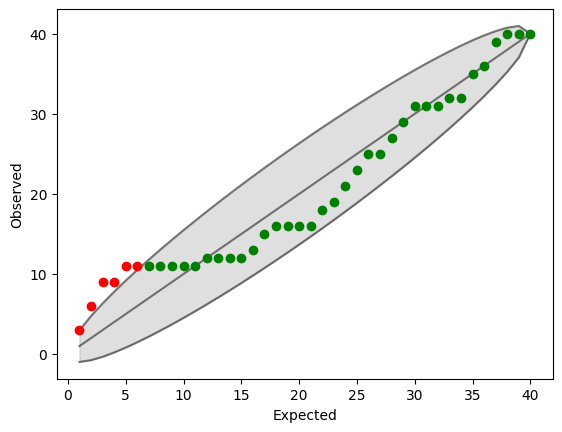

In [15]:
_ = dds.extremes_plot(X_train_dds, upper_frac=1.0)

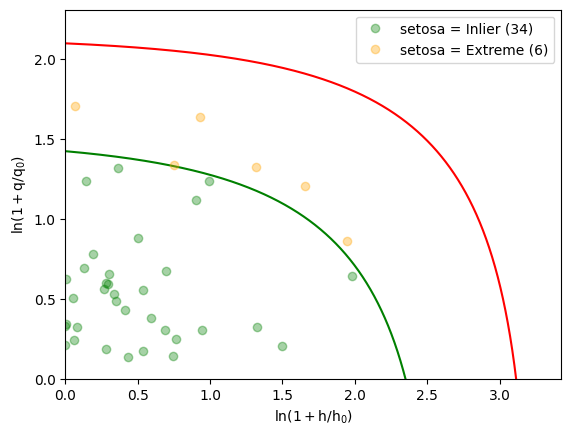

In [16]:
# There are no outliers in this training set, so we don't have to worry about removing any points (at least for this
# n_components).
_ = dds.visualize(X_train_dds, y_train_dds)

In [17]:
# Extremes and Outliers can be found using the check_outliers() function.
extremes_mask, outliers_mask = dds.check_outliers(X_train_dds)

print(
    "There are {} extremes and {} outliers in the training data.".format(
        np.sum(extremes_mask),
        np.sum(outliers_mask)
    )
)

There are 6 extremes and 0 outliers in the training data.


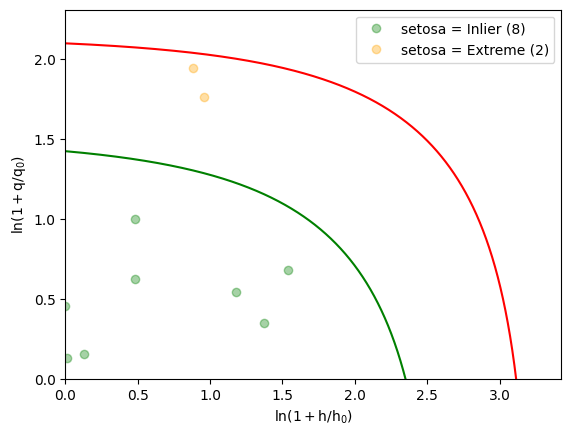

In [18]:
_ = dds.visualize(X_test_dds, y_test_dds)

In [19]:
# We can see what samples are classified as 'Pure' using the predict() function.
pure_sample_mask = dds.predict(X_test_dds)

# These are accepted as authentic.
X_test_dds[pure_sample_mask]

array([[4.4, 3. , 1.3, 0.2],
       [4.4, 3.2, 1.3, 0.2],
       [5.4, 3.4, 1.7, 0.2],
       [5. , 3.4, 1.5, 0.2],
       [5. , 3.3, 1.4, 0.2],
       [5.4, 3.7, 1.5, 0.2],
       [5.7, 3.8, 1.7, 0.3],
       [5.2, 3.4, 1.4, 0.2]])

In [20]:
# These are rejected
X_test_dds[~pure_sample_mask]

array([[4.6, 3.6, 1. , 0.2],
       [5.8, 4. , 1.2, 0.2]])

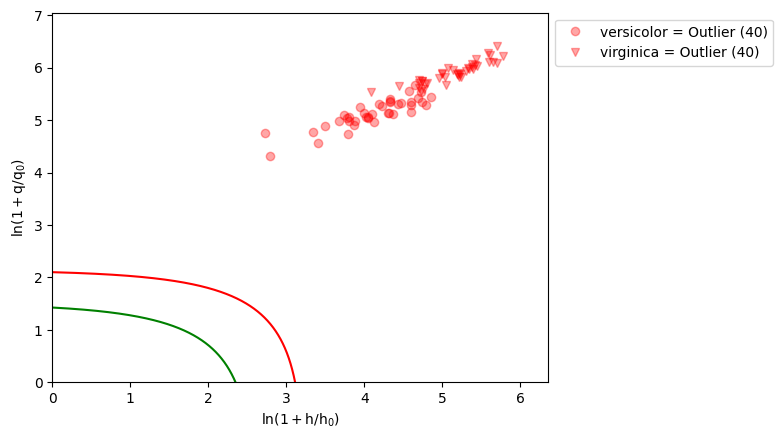

In [21]:
# We can also look at well the model rejects the other classes as authentic setosa
X_other = X_train[y_train != chosen_class]
y_other = y_train[y_train != chosen_class]

# At least this model seems very specific since these other classes are easily rejected!
_ = dds.visualize(X_other, y_other)

In [22]:
# Accuracy is computed by simply counting the number of binary (authentic/not) assignments.
train_acc = dds.accuracy(
    X = X_train_dds,
    y = [True] * len(X_train_dds) # We do not use y_train here!
)

test_acc = dds.accuracy(
    X = X_test_dds,
    y = [True] * len(X_test_dds)
)

print(
    "Training set accuracy = {}%; test set accuracy = {}%.".format(
        '%.1f'%(100.0*train_acc),
        '%.1f'%(100.0*test_acc)
    )
)

Training set accuracy = 85.0%; test set accuracy = 80.0%.


In [23]:
# Accuracy is also reported as the score
dds.score(X_train_dds, [True] * len(X_train_dds))

0.85

Building an Authenticator
---

In training loops and other applications it is convenient to not have to separate classes for training.  This is one thing that SIMCA_Authenticator conveniently does for you, which is illustrated below.  Here, we simply specify the class we care about and all others are automatically ignored like we did manually above.  

Another factor we need to consider is that there are 2 ways to train an authentication model [1].  A "rigorous" approach would be to train a model considering only the true examples of a known class.  We could select a desired `alpha` value and adjust `n_components` to try to achieve this, since it is the desired type I error rate.  This is essentially like setting the accuracy for true positives (TSNS), while ignoring the behavior with respect to alternative classes.  

Alternatively, we could use examples of alternatives and adjust our hyperparameters to optimize an overall metric like total efficiency (TEFF) which considers how often we get true positives correct (TSNS) and how often we correctly reject the true negatives (TSPS). This is a "compliant" approach. These sorts of models use more information and might seem more performant, but this data is always biased by the set of known alternatives we use.  Since there are an infinite number of inauthentic things, this introduces some bias which can be difficult to quantify.

[[1] "Rigorous and compliant approaches to one-class classification," Rodionova, O., Oliveri, P., and Pomerantsev, A. Chem. and Intell. Lab. Sys. (2016) 89-96.](https://doi.org/10.1016/j.chemolab.2016.10.002)


In [24]:
from pychemauth.classifier.simca import SIMCA_Authenticator

In [25]:
# First let's consider a compliant model
compliant = SIMCA_Authenticator(
    n_components=1,
    alpha=0.05,
    gamma=0.01,
    scale_x=True,
    style='dd-simca',
    robust="semi",
    sft=False,
    target_class='setosa', # Tell the classifier which class to use
    use='compliant' # Using a compliant approach will use the other classes provided at training time
)

In [26]:
# Note that y_train should contain examples of the target_class or else an exception will be thrown.  Otherwise,
# all other classes will be used by the model to optimize TEFF
_ = compliant.fit(X_train, y_train)

In [27]:
compliant.metrics(X_train, y_train)

{'TEFF': 0.9219544457292888,
 'TSNS': 0.85,
 'TSPS': 1.0,
 'CSPS': {'versicolor': 1.0, 'virginica': 1.0}}

In [28]:
# Now consider a rigorous model
rigorous = SIMCA_Authenticator(
    n_components=1,
    alpha=0.05,
    gamma=0.01,
    scale_x=True,
    style='dd-simca',
    robust="semi",
    sft=False,
    target_class='setosa', # Tell the classifier which class to use
    use='rigorous'
)

In [29]:
_ = rigorous.fit(X_train, y_train)

In [30]:
rigorous.metrics(X_train, y_train)

{'TEFF': 0.9219544457292888,
 'TSNS': 0.85,
 'TSPS': 1.0,
 'CSPS': {'versicolor': 1.0, 'virginica': 1.0}}

The metrics are identical!  This is because the choice of rigorous vs. compliant has nothing to do with the <b>training</b> of the model.  This is important when we <b>optimize</b> the model since it determines what the optimal model looks like; i.e., should it be the one with the TSNS ~ 1-alpha, or the one with the best TEFF?


In [31]:
# The compliant model's score is the TEFF.
compliant.score(X_train, y_train)

0.9219544457292888

In [32]:
# We score a rigorous model as -(TSNS - (1-alpha))^2, so that a higher score is better (least negative) and a score of
# 0 corresponds to hitting the target exactly.
rigorous.score(X_train, y_train)

-0.009999999999999995

Optimizing the Authenticator
---

<h3>Compliant Model</h3>

In [33]:
compliant_pipeline = imblearn.pipeline.Pipeline(
    steps=[
        ("simca", SIMCA_Authenticator(
            n_components=1,
            alpha=0.05,
            gamma=0.01,
            scale_x=True,
            style='dd-simca',
            target_class='setosa',
            use='compliant'
        )
    )
])

param_grid = [{
    'simca__n_components':np.arange(1, 4),
    'simca__alpha': np.logspace(-3, np.log10(0.5), 10), # For compliant models we also adjust alpha to optimize TEFF
}]

gs = GridSearchCV(
    estimator=compliant_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [34]:
gs.best_params_

{'simca__alpha': 0.001, 'simca__n_components': 2}

In [35]:
print("Test set TEFF = {}; training set TEFF = {}".format(
    '%.3f'%(gs.score(X_test, y_test)),
    '%.3f'%(gs.score(X_train, y_train)),
    )
)

Test set TEFF = 1.000; training set TEFF = 1.000


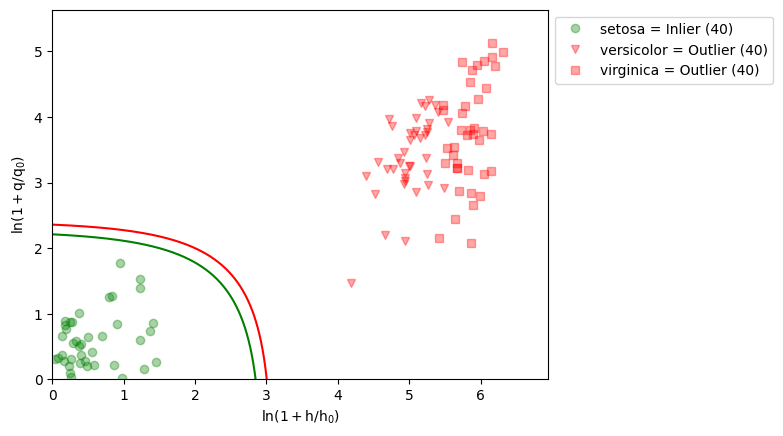

In [36]:
# We can access the underlying DDSIMCA_Model like this
best_authenticator = gs.best_estimator_["simca"]
ddsimca_model = best_authenticator.model

_ = ddsimca_model.visualize(X_train, y_train)

In [37]:
best_authenticator.metrics(X_train, y_train)

{'TEFF': 1.0,
 'TSNS': 1.0,
 'TSPS': 1.0,
 'CSPS': {'versicolor': 1.0, 'virginica': 1.0}}

In [38]:
best_authenticator.metrics(X_test, y_test)

{'TEFF': 1.0,
 'TSNS': 1.0,
 'TSPS': 1.0,
 'CSPS': {'versicolor': 1.0, 'virginica': 1.0}}

<h3>Rigorous Model</h3>

In [39]:
rigorous_pipeline = imblearn.pipeline.Pipeline(
    steps=[
        ("simca", SIMCA_Authenticator(
            n_components=1,
            alpha=0.05,
            gamma=0.01,
            scale_x=True,
            style='dd-simca',
            target_class='setosa',
            use='rigorous'
        )
    )
])

param_grid = [{
    'simca__n_components':np.arange(1, 4), # Now we fix alpha and adjust n_components to reach this value
}]

gs = GridSearchCV(
    estimator=rigorous_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [40]:
# The rigorous model turns out to have the same parameters as the compliant one
gs.best_params_

{'simca__n_components': 2}

In [41]:
# The "score" is different here, though.
print("Test set score = {}; training set score = {}".format(
    '%.4f'%(gs.score(X_test, y_test)),
    '%.4f'%(gs.score(X_train, y_train)),
    )
)

Test set score = -0.0025; training set score = -0.0006


In [42]:
# We can manually compute these scores
tsns_test = np.sum(gs.predict(X_test[y_test == 'setosa'])) / np.sum(y_test == 'setosa')
(tsns_test - (1.0 - 0.05))**2

0.0024999999999999935

In [43]:
# We can manually compute these scores
tsns_train = np.sum(gs.predict(X_train[y_train == 'setosa'])) / np.sum(y_train == 'setosa')
(tsns_train - (1.0 - 0.05))**2

0.0006249999999999956

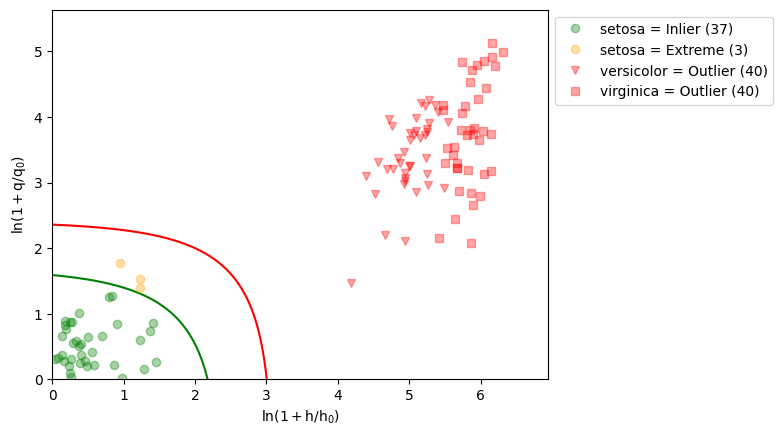

In [44]:
best_authenticator = gs.best_estimator_["simca"]
ddsimca_model = best_authenticator.model

_ = ddsimca_model.visualize(X_train, y_train)

In [45]:
best_authenticator.metrics(X_train, y_train)

{'TEFF': 0.9617692030835673,
 'TSNS': 0.925,
 'TSPS': 1.0,
 'CSPS': {'versicolor': 1.0, 'virginica': 1.0}}

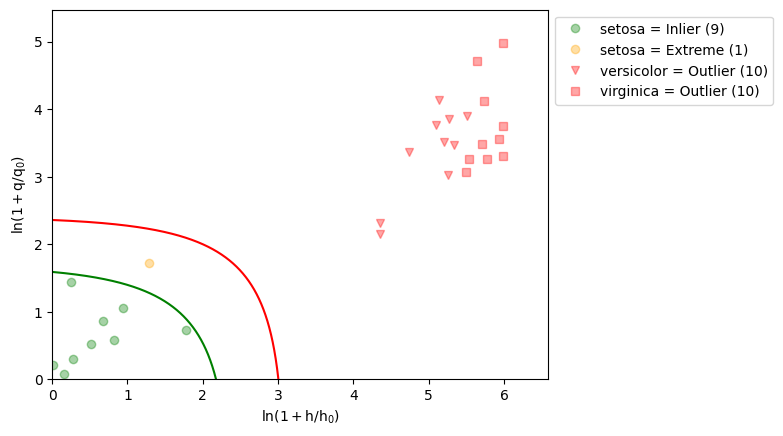

In [46]:
_ = ddsimca_model.visualize(X_test, y_test)

In [47]:
best_authenticator.metrics(X_test, y_test)

{'TEFF': 0.9486832980505138,
 'TSNS': 0.9,
 'TSPS': 1.0,
 'CSPS': {'versicolor': 1.0, 'virginica': 1.0}}